In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime  import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error as mae
import io

energy_demand =pd.read_csv('/content/victoria state dataset.csv')
energy_demand.head()
energy_demand.shape
df=energy_demand.copy()
df['date']=pd.to_datetime(df['date'])
df.rainfall.fillna(df.rainfall.median(), inplace=True)

df.solar_exposure.fillna(df.solar_exposure.median(), inplace=True)
df.info()
df.isna().sum()
#To extract the year
df['Year'] = df['date'].dt.year
#To extract the month
df['Month'] = df['date'].dt.month
#To extract the day
df['Day'] = df['date'].dt.day

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2106 non-null   datetime64[ns]
 1   demand           2106 non-null   float64       
 2   RRP              2106 non-null   float64       
 3   demand_pos_RRP   2106 non-null   float64       
 4   RRP_positive     2106 non-null   float64       
 5   demand_neg_RRP   2106 non-null   float64       
 6   RRP_negative     2106 non-null   float64       
 7   frac_at_neg_RRP  2106 non-null   float64       
 8   min_temperature  2106 non-null   float64       
 9   max_temperature  2106 non-null   float64       
 10  solar_exposure   2106 non-null   float64       
 11  rainfall         2106 non-null   float64       
 12  school_day       2106 non-null   object        
 13  holiday          2106 non-null   object        
dtypes: datetime64[ns](1), float64(11), objec

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from tqdm import tqdm

def jitter(x, sigma=0.03):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])

    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])

    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

In [ ]:
import numpy as np

def plot2d(x, y, x2=None, y2=None, x3=None, y3=None, xlim=(-1, 1), ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(4, 4))
    plt.plot(x, y)
    if x2 is not None and y2 is not None:
        plt.plot(x2, y2)
    if x3 is not None and y3 is not None:
        plt.plot(x3, y3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, "")
    else:
        plt.show()
    return

def plot1d(x, x2=None, x3=None, ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    steps = np.arange(x.shape[0])
    plt.plot(steps, x)
    if x2 is not None:
        plt.plot(steps, x2)
    if x3 is not None:
        plt.plot(steps, x3)
    plt.xlim(0, x.shape[0])
    plt.ylim(ylim)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, "")
    else:
        plt.show()
    return

In [ ]:
df_1=df.copy()
norm_scale=MinMaxScaler()
df_scaled=norm_scale.fit_transform(df_1[['RRP','demand','demand_pos_RRP','RRP_positive', 'demand_neg_RRP', 'RRP_negative','min_temperature',
                                         'max_temperature', 'solar_exposure', 'rainfall']])
df_scaled=pd.DataFrame(df_scaled, columns=['RRP','demand','demand_pos_RRP','RRP_positive', 'demand_neg_RRP', 'RRP_negative','min_temperature',
                                         'max_temperature', 'solar_exposure', 'rainfall'])
df_scaled['date']=df_1['date']
df_scaled['holiday']=df_1['holiday']
df_scaled['school_day']=df_1['school_day']
df_scaled=pd.get_dummies(df_scaled)
df_scaled.shape
df_ready=df_scaled.dropna()
df_ready.date.shape
df_train = df_ready[df_ready.date<='2019-01-01']
#Test dataset
df_test =  df_ready[df_ready.date>'2019-01-01']
#A reserved copy of the test dataset for plotting
df_resid = df_ready[df_ready.date>'2019-01-01']

#Extract the target feature for training and testing
y_train=df_train["demand"]
y_test=df_test["demand"]

#Extracting the independent features for training and testing
X_train =df_train.drop(labels=['demand', 'date'], axis=1)
X_test=df_test.drop(labels=['demand', 'date'], axis=1)
df_train.shape
print(f'X_train:', len(X_train))
print(f'y_train:', len(y_train))
print(f'X_test:', len(X_test))
print(f'y_tets:', len(y_test))

X_train: 1462
y_train: 1462
X_test: 644
y_tets: 644


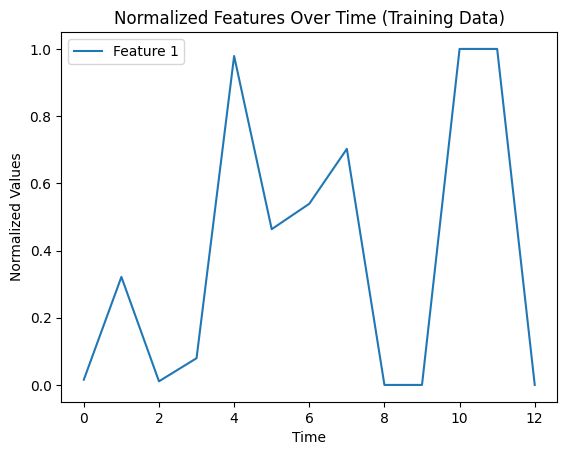

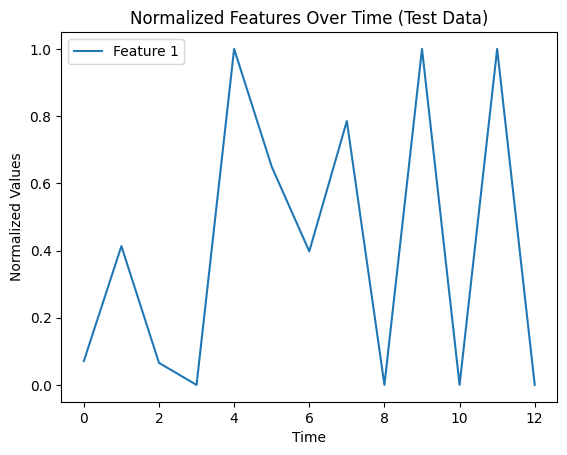

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Assuming df_train and df_test are your DataFrames from the second code snippet

# Drop unnecessary columns
X_train = df_train.drop(labels=['demand', 'date'], axis=1)
X_test = df_test.drop(labels=['demand', 'date'], axis=1)

# Convert to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

# Normalize the features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_array)
X_test_normalized = scaler.transform(X_test_array)

# Reshape for visualization
nb_timesteps = X_train_normalized.shape[1]
input_shape = (nb_timesteps, 1)  # Assuming each feature is considered as a timestep
X_train_reshaped = X_train_normalized.reshape((-1, input_shape[0], input_shape[1]))
X_test_reshaped = X_test_normalized.reshape((-1, input_shape[0], input_shape[1]))

# Plot the first training sample
plt.plot(X_train_reshaped[0, :, 0], label='Feature 1')
# Add more lines for additional features if needed
# plt.plot(X_train_reshaped[0, :, 1], label='Feature 2')
# ...
plt.title('Normalized Features Over Time (Training Data)')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()

# Similarly, you can plot for the test data
plt.plot(X_test_reshaped[0, :, 0], label='Feature 1')
# Add more lines for additional features if needed
# plt.plot(X_test_reshaped[0, :, 1], label='Feature 2')
# ...
plt.title('Normalized Features Over Time (Test Data)')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()


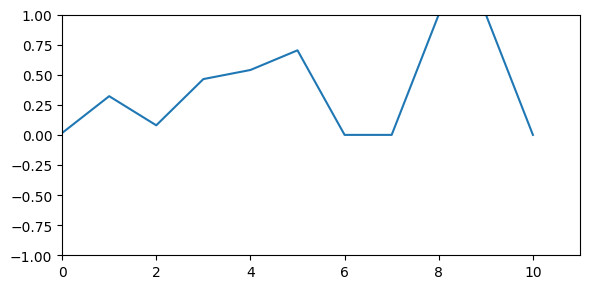

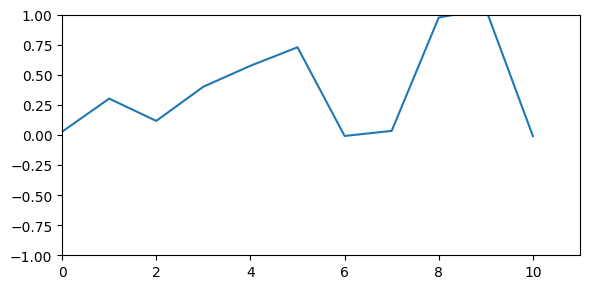

In [ ]:
plot1d(X_train_reshaped[0, :, 0])
plot1d(jitter(X_train_reshaped[0, :, 0]))

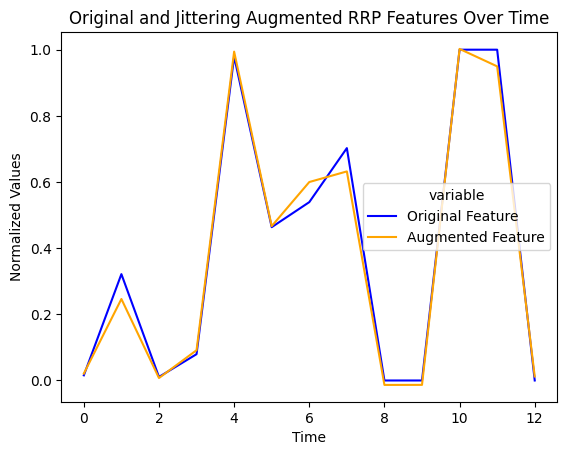

In [ ]:
# Assuming X_train_reshaped is your reshaped training data and jittered version
original_feature = X_train_reshaped[0, :, 0]
augmented_feature = jitter(X_train_reshaped[0, :, 0])

# Combine the data into a DataFrame
data = pd.DataFrame({'Time': range(len(original_feature)),
                     'Original Feature': original_feature,
                     'Augmented Feature': augmented_feature})

# Melt the DataFrame to long format for Seaborn
data_melted = pd.melt(data, id_vars=['Time'], value_vars=['Original Feature', 'Augmented Feature'])

# Use Seaborn to plot both features in a single plot
sns.lineplot(data=data_melted, x='Time', y='value', hue='variable', palette=['blue', 'orange'])

plt.title('Original and Jittering Augmented RRP Features Over Time')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
#plt.legend()
plt.show()

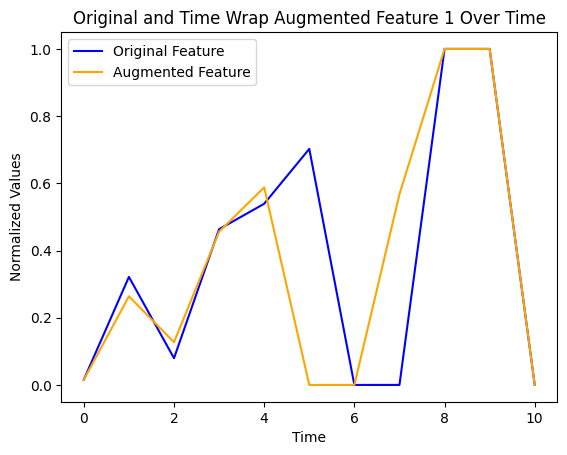

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import CubicSpline

# Assuming df_train and df_test are your DataFrames from the second code snippet

# Define the time_warp function
def time_warp(x, sigma=0.2, knot=4):
    orig_steps = np.arange(x.shape[1])

    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2], 1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:, dim], warp_steps[:, dim] * random_warps[i, :, dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i, :, dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:, dim]).T
    return ret

# Drop unnecessary columns
X_train = df_train.drop(labels=['demand', 'date'], axis=1)
X_test = df_test.drop(labels=['demand', 'date'], axis=1)

# Convert to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

# Normalize the features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_array)
X_test_normalized = scaler.transform(X_test_array)

# Reshape for visualization
nb_timesteps = X_train_normalized.shape[1]
input_shape = (nb_timesteps, 1)  # Assuming each feature is considered as a timestep
X_train_reshaped = X_train_normalized.reshape((-1, input_shape[0], input_shape[1]))
X_test_reshaped = X_test_normalized.reshape((-1, input_shape[0], input_shape[1]))

# Apply time warping augmentation
X_train_augmented = time_warp(X_train_reshaped)

# Visualize each feature separately
for feature_index in range(X_train_reshaped.shape[2]):
    original_feature = X_train_reshaped[0, :, feature_index]
    augmented_feature = X_train_augmented[0, :, feature_index]

    # Combine the data into a DataFrame
    data = pd.DataFrame({'Time': range(len(original_feature)),
                         'Original Feature': original_feature,
                         'Augmented Feature': augmented_feature})

    # Melt the DataFrame to long format for Seaborn
    data_melted = pd.melt(data, id_vars=['Time'], value_vars=['Original Feature', 'Augmented Feature'])

    # Use Seaborn to plot both features in a single plot
    sns.lineplot(data=data_melted, x='Time', y='value', hue='variable', palette=['blue', 'orange'])

    plt.title(f'Original and Time Wrap Augmented Feature {feature_index + 1} Over Time')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.show()


In [ ]:
plt.savefig(f'Jittering Augmentaion_plot.png', dpi=700)

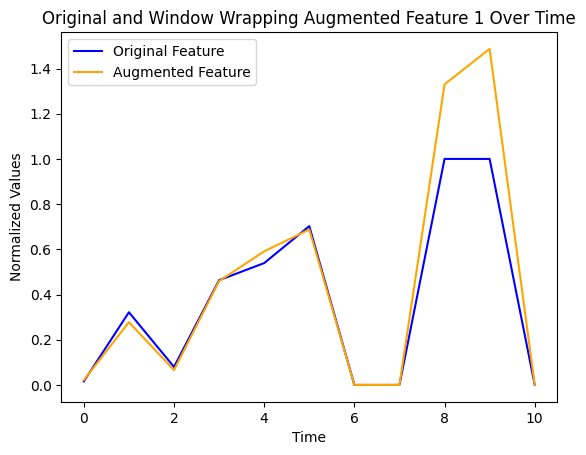

In [ ]:
# Drop unnecessary columns
X_train = df_train.drop(labels=['demand', 'date'], axis=1)
X_test = df_test.drop(labels=['demand', 'date'], axis=1)

# Convert to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

# Normalize the features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_array)
X_test_normalized = scaler.transform(X_test_array)

# Reshape for visualization
nb_timesteps = X_train_normalized.shape[1]
input_shape = (nb_timesteps, 1)  # Assuming each feature is considered as a timestep
X_train_reshaped = X_train_normalized.reshape((-1, input_shape[0], input_shape[1]))
X_test_reshaped = X_test_normalized.reshape((-1, input_shape[0], input_shape[1]))

# Apply time warping augmentation
X_train_augmented = magnitude_warp(X_train_reshaped)

# Visualize each feature separately
for feature_index in range(X_train_reshaped.shape[2]):
    original_feature = X_train_reshaped[0, :, feature_index]
    augmented_feature = X_train_augmented[0, :, feature_index]

    # Combine the data into a DataFrame
    data = pd.DataFrame({'Time': range(len(original_feature)),
                         'Original Feature': original_feature,
                         'Augmented Feature': augmented_feature})

    # Melt the DataFrame to long format for Seaborn
    data_melted = pd.melt(data, id_vars=['Time'], value_vars=['Original Feature', 'Augmented Feature'])

    # Use Seaborn to plot both features in a single plot
    sns.lineplot(data=data_melted, x='Time', y='value', hue='variable', palette=['blue', 'orange'])

    plt.title(f'Original and Window Wrapping Augmented Feature {feature_index + 1} Over Time')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.show()

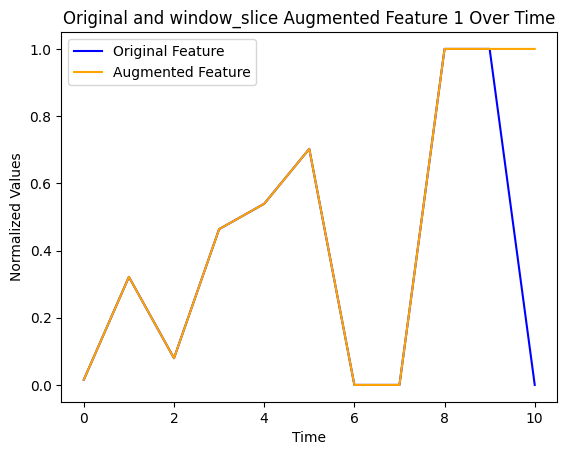

In [ ]:
# Drop unnecessary columns
X_train = df_train.drop(labels=['demand', 'date'], axis=1)
X_test = df_test.drop(labels=['demand', 'date'], axis=1)

# Convert to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

# Normalize the features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_array)
X_test_normalized = scaler.transform(X_test_array)

# Reshape for visualization
nb_timesteps = X_train_normalized.shape[1]
input_shape = (nb_timesteps, 1)  # Assuming each feature is considered as a timestep
X_train_reshaped = X_train_normalized.reshape((-1, input_shape[0], input_shape[1]))
X_test_reshaped = X_test_normalized.reshape((-1, input_shape[0], input_shape[1]))

# Apply time warping augmentation
X_train_augmented = window_slice(X_train_reshaped)

# Visualize each feature separately
for feature_index in range(X_train_reshaped.shape[2]):
    original_feature = X_train_reshaped[0, :, feature_index]
    augmented_feature = X_train_augmented[0, :, feature_index]

    # Combine the data into a DataFrame
    data = pd.DataFrame({'Time': range(len(original_feature)),
                         'Original Feature': original_feature,
                         'Augmented Feature': augmented_feature})

    # Melt the DataFrame to long format for Seaborn
    data_melted = pd.melt(data, id_vars=['Time'], value_vars=['Original Feature', 'Augmented Feature'])

    # Use Seaborn to plot both features in a single plot
    sns.lineplot(data=data_melted, x='Time', y='value', hue='variable', palette=['blue', 'orange'])

    plt.title(f'Original and window_slice Augmented Feature {feature_index + 1} Over Time')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.show()

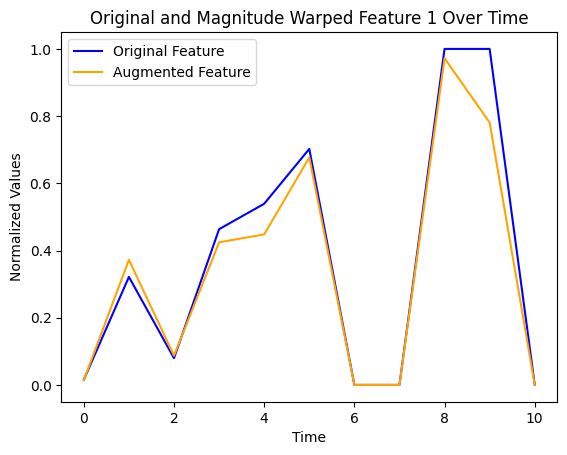

In [ ]:
# Drop unnecessary columns
X_train = df_train.drop(labels=['demand', 'date'], axis=1)
X_test = df_test.drop(labels=['demand', 'date'], axis=1)

# Convert to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

# Normalize the features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_array)
X_test_normalized = scaler.transform(X_test_array)

# Reshape for visualization
nb_timesteps = X_train_normalized.shape[1]
input_shape = (nb_timesteps, 1)  # Assuming each feature is considered as a timestep
X_train_reshaped = X_train_normalized.reshape((-1, input_shape[0], input_shape[1]))
X_test_reshaped = X_test_normalized.reshape((-1, input_shape[0], input_shape[1]))

# Apply time warping augmentation
# Apply magnitude warping augmentation
X_train_augmented = magnitude_warp(X_train_reshaped)

# Visualize each feature separately
for feature_index in range(X_train_reshaped.shape[2]):
    original_feature = X_train_reshaped[0, :, feature_index]
    augmented_feature = X_train_augmented[0, :, feature_index]

    # Combine the data into a DataFrame
    data = pd.DataFrame({'Time': range(len(original_feature)),
                         'Original Feature': original_feature,
                         'Augmented Feature': augmented_feature})

    # Melt the DataFrame to long format for Seaborn
    data_melted = pd.melt(data, id_vars=['Time'], value_vars=['Original Feature', 'Augmented Feature'])

    # Use Seaborn to plot both features in a single plot
    sns.lineplot(data=data_melted, x='Time', y='value', hue='variable', palette=['blue', 'orange'])

    plt.title(f'Original and Magnitude Warped Feature {feature_index + 1} Over Time')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.show()


In [ ]:
# Assuming energy_demand is your DataFrame
features_to_visualize = list(energy_demand.columns)[1:]  # Exclude the 'date' column

# Loop through each feature and print its index
for feature_name in features_to_visualize:
    feature_index = energy_demand.columns.get_loc(feature_name) - 1  # Adjust index to start from 0
    print(f"Feature: {feature_name}, Index: {feature_index}")


Feature: demand, Index: 0
Feature: RRP, Index: 1
Feature: demand_pos_RRP, Index: 2
Feature: RRP_positive, Index: 3
Feature: demand_neg_RRP, Index: 4
Feature: RRP_negative, Index: 5
Feature: frac_at_neg_RRP, Index: 6
Feature: min_temperature, Index: 7
Feature: max_temperature, Index: 8
Feature: solar_exposure, Index: 9
Feature: rainfall, Index: 10
Feature: school_day, Index: 11
Feature: holiday, Index: 12


In [ ]:
df.head

<bound method NDFrame.head of            date      demand        RRP  demand_pos_RRP  RRP_positive  \
0    2015-01-01   99635.030  25.633696       97319.240     26.415953   
1    2015-01-02  129606.010  33.138988      121082.015     38.837661   
2    2015-01-03  142300.540  34.564855      142300.540     34.564855   
3    2015-01-04  104330.715  25.005560      104330.715     25.005560   
4    2015-01-05  118132.200  26.724176      118132.200     26.724176   
...         ...         ...        ...             ...           ...   
2101 2020-10-02   99585.835  -6.076028       41988.240     26.980251   
2102 2020-10-03   92277.025  -1.983471       44133.510     32.438156   
2103 2020-10-04   94081.565  25.008614       88580.995     26.571687   
2104 2020-10-05  113610.030  36.764701      106587.375     39.616015   
2105 2020-10-06  122607.560  75.771059      122607.560     75.771059   

      demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
0           2315.790     -7.24000

In [ ]:
import tsgm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

numeric_features_for_dtwba = ['demand', 'RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP',
                       'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall']

# Normalize numeric features
numeric_scaler = MinMaxScaler()
df[numeric_features_for_dtwba] = numeric_scaler.fit_transform(df[numeric_features_for_dtwba])

# Extract non-numeric features
non_numeric_features = ['school_day', 'holiday']

# One-hot encode non-numeric features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_non_numeric = encoder.fit_transform(df[non_numeric_features])

# Combine numeric and encoded non-numeric features
X_numeric = df[numeric_features_for_dtwba].values
X_combined = np.concatenate([X_numeric, encoded_non_numeric], axis=1)

# Create DTWBA model
aug_model = tsgm.models.augmentations.DTWBarycentricAveraging()

# Choose initial time series for DTWBA
initial_timeseries_idx = np.random.choice(X_combined.shape[0], 10, replace=False)
initial_timeseries = X_combined[initial_timeseries_idx]

# Generate augmented samples
n_samples = 10  # You can adjust this as needed
augmented_samples = aug_model.generate(X=X_combined, n_samples=n_samples, initial_timeseries=initial_timeseries)

# Convert augmented samples to DataFrame
augmented_df = pd.DataFrame(np.vstack(augmented_samples), columns=numeric_features_for_dtwba + [f'encoded_{feature}' for feature in non_numeric_features])

# Inverse transform the numeric features to the original scale
augmented_df[numeric_features_for_dtwba] = numeric_scaler.inverse_transform(augmented_df[numeric_features_for_dtwba])

# Display the augmented dataset
print(augmented_df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


     demand       RRP  demand_pos_RRP  RRP_positive  demand_neg_RRP  \
0  0.410116  0.021051        0.593892      0.012989        0.015315   
1  0.408384  0.020590        0.579628      0.013029        0.010457   
2  0.409101  0.023310        0.595550      0.013584        0.011736   
3  0.408384  0.021706        0.598974      0.013250        0.011286   
4  0.408673  0.026706        0.575647      0.013598        0.012632   

   RRP_negative  frac_at_neg_RRP  min_temperature  max_temperature  \
0      0.986673         0.036320         0.399789         0.361635   
1      0.982468         0.053035         0.452456         0.497997   
2      0.986223         0.019340         0.395809         0.378771   
3      0.989743         0.045477         0.436792         0.376304   
4      0.968918         0.014329         0.315742         0.227454   

   solar_exposure  rainfall  encoded_school_day  encoded_holiday  
0        0.122375  0.105134            0.865401         0.038466  
1        0.556094 